Result(backend_name='aer_simulator_density_matrix', backend_version='0.15.1', qobj_id='', job_id='23bc694b-692a-47e6-9b85-afa0a0d1a429', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(creg_sizes=[], global_phase=5.341214509554172, memory_slots=0, n_qubits=7, name='circuit-821', qreg_sizes=[['q', 7]], metadata={}), status=DONE, seed_simulator=1794225413, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 11, 'parallel_shots': 1, 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [], 'device': 'CPU', 'time_taken': 2.075e-05, 'measure_sampling': False, 'num_clbits': 0, 'max_memory_mb': 18432, 'input_qubit_map': [], 'num_qubits': 0, 'method': 'density_matrix', 'required_memory_mb': 1}, time_taken=2.075e-05)], date=2025-02-06T18:14:35.081160, status=COMPLETED, header=None, metadata={'time_taken_parameter_binding': 9.625e-06, 'max

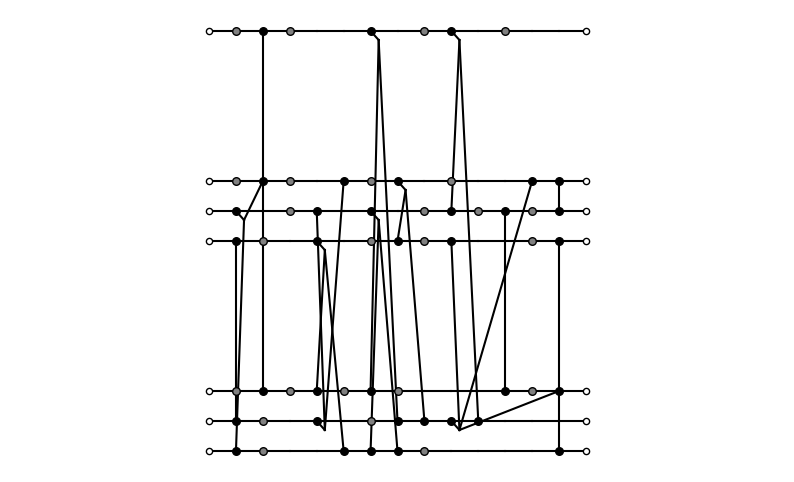

In [138]:
from circuits.cp_fraction import cp_fraction
from src.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from src.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from circuits.QAOA import QAOA_random
import numpy as np

num_qubits = 7
num_partitions = 3
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=2*num_qubits,
                        fraction= 0.5)

# circuit = QFT(num_qubits, do_swaps=False)


# circuit = QuantumCircuit(num_qubits)
 
# for i in range(num_qubits):
#     circuit.h(i)
# for j in range(num_qubits-1):
#     for i in range(j,num_qubits-1):
#         circuit.cp(np.pi/2, j, i+1)



circuit = transpile(circuit, basis_gates = ['cp', 'u'])

from qiskit_aer import AerSimulator

simulator = AerSimulator(method='density_matrix')

# circuit = transpile(circuit, basis_gates = ['cp', 'u'])

result = simulator.run([circuit], shots=1024)

print(result.result())

depth = circuit.depth()

from src.qiskit_to_op_list import *
layers = circuit_to_gate_layers(circuit)

from src.greedy_gate_grouping import group_distributable_packets

group_gates = True

if group_gates:
    layers = group_distributable_packets(layers, num_qubits)

layers = layer_list_to_dict(layers)

graph = QuantumCircuitHyperGraph(num_qubits=num_qubits, depth=depth)
graph.map_circuit_to_hypergraph(circuit, group_gates = group_gates, anti_diag = False)

assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

print(assignment)

from src.tikz_drawing import *
from src.mpl_drawing import *

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

In [139]:

def layers_pre_processing(layers):
    for i, layer in layers.items():
        for gate in layer:
            print(gate)

    print('=========================================')

    def layers_pre_processing(layers):
        for i, layer in layers.items():
            for k, gate in enumerate(layer):
                if gate['type'] == 'group':
                    print(gate)
                    print(len(gate['sub-gates']))
                    if len(gate['sub-gates']) == 1:
                        new_gate = gate['sub-gates'][0]
                        del new_gate['time']
                        layer[k] = new_gate
                    elif len(gate['sub-gates']) == 0:
                        layer.pop(k)
        return layers

    layers = layers_pre_processing(layers)

    print('=========================================')
    for i, layer in layers.items():
        for gate in layer:
            print(gate)

    return layers


In [140]:
# from qiskit import QuantumCircuit, QuantumRegister

# class CommunicationQubitManager:
#     """
#     Manages communication qubits on a per-partition-pair basis.
    
#     For each partition pair (p1, p2) (with p1 < p2 for consistency),
#     the manager tracks:
#       - A pool of free communication qubit pairs.
#       - A dictionary of in-use pairs along with metadata:
#            - The current "root" qubit info (which may include its current physical location)
#            - Other info you might need to apply corrections.
#     """
#     def __init__(self, comm_qregs : list, qc: QuantumCircuit):
#         self.qc = qc
#         # Free comm qubit pairs: keys are tuples (p1, p2); value is a list of (q0, q1) tuples.
#         self.free_comm = {}
#         self.in_use_comm = {}
#         self.comm_qregs = comm_qregs
#         for p, reg_list in comm_qregs.items():
#             self.free_comm[p] = []
#             self.in_use_comm[p] = []
#             for reg in reg_list:
#                 for qubit in reg:
#                     self.free_comm[p].append(qubit)
#                     print(f"Adding qubit {qubit} to free comm qubits for partition {p}")
    
#         self.linked_qubits = {}

#     def find_comm_idx(self, p):
#         free_comm_p_root = self.free_comm.get(p, [])
#         print(f"Free comm qubits for partition {p}: {free_comm_p_root}")
#         if free_comm_p_root != []:
#             comm_qubit = free_comm_p_root.pop(0)
#         else:
#             # Create a new communication pair by adding a new register of 2 qubits.
#             print(self.comm_qregs)
#             num_regs_p_root = len(self.comm_qregs[p])
#             print(f"Creating new comm qubit pair for partition {p} with index {num_regs_p_root}")
#             idx = num_regs_p_root
#             new_reg = QuantumRegister(1, name=f"comm_{p}_{idx}")
#             self.comm_qregs[p].append(new_reg)
#             self.qc.add_register(new_reg)
#             comm_qubit = new_reg[0]

#         self.in_use_comm[p].append(comm_qubit)

#         return comm_qubit

#     def allocate_comm_qubits(self, root_q, p_root, p_set_rec):
#         """
#         Allocate a pair of communication qubits for a partition pair (p1, p2)
#         and associate them with the given root.
        
#         The root_info dictionary should at least contain:
#           - "qubit": the Qiskit qubit object for the root.
#           - "location": the current partition (or physical slot) where the root resides.
#         """
#         comm_root = self.find_comm_idx(p_root)


#         comm_rec_dict = {}
#         print(f'Set of receiving partitions: {p_set_rec}')
#         for p_rec in p_set_rec:
#             comm_rec = self.find_comm_idx(p_rec)
#             comm_rec_dict[p_rec]= comm_rec
#             print(f"Allocating comm qubit {comm_rec} for partition {p_rec}")
#             self.linked_qubits[comm_rec] = root_q
#             print(f"Linking comm qubit {comm_rec} to root qubit {root_q}")

#         return comm_root, comm_rec_dict

#     def release_comm_qubit(self, qc, p, comm_qubit):
#         """
#         When a sub-gate is the last one in a given partition for a given
#         teleportation chain, release the communication qubit so that it becomes free again.
#         """
#         qc.reset(comm_qubit)
#         self.free_comm[p].append(comm_qubit)
#         self.in_use_comm[p].remove(comm_qubit)
#         print(f"Releasing comm qubit {comm_qubit} for partition {p}")
             

#     def get_status(self, p1, p2):
#         """
#         For debugging or logging: return a tuple of (in-use, free) comm pairs for partition pair (p1, p2).
#         """
#         key = self._key(p1, p2)
#         in_use = self.in_use_comm.get(key, {})
#         free = self.free_comm.get(key, [])
#         return in_use, free
    
# class ClassicalBitManager:
#     """

#     """
#     def __init__(self, qc, creg : ClassicalRegister):
#         # Free comm qubit pairs: keys are tuples (p1, p2); value is a list of (q0, q1) tuples.
#         self.free_cbit = []
#         self.in_use_cbit = {}
#         self.creg = creg
#         self.qc = qc
#         for cbit in self.creg:
#             self.free_cbit.append(cbit)

#     def allocate_cbit(self):
#         if len(self.free_cbit) == 0:
#             idx = len(self.creg)
#             self.qc.append(ClassicalRegister(1, name=f"c_{idx}"))
#             self.free_cbit.append(self.creg[-1][0])
#         return self.free_cbit.pop(0)
    
#     def release_cbit(self, cbit):
#         self.free_cbit.insert(0, cbit)

# class DataQubitManager:
#     def __init__(self, partition_qregs, num_qubits_log, partition_assignment, qc):
#         self.qc = qc
#         self.partition_qregs = partition_qregs
#         self.num_qubits_log = num_qubits_log
#         self.in_use_data = {}
#         self.free_data = {}
#         self.partition_qregs = partition_qregs
#         self.num_qubits_log = num_qubits_log
#         self.partition_assignment = partition_assignment
#         self.initial_partition = partition_assignment[0]
#         self.log_to_phys_idx = {}
#         self.usage_counters = [0]*num_partitions
#         self.num_data_qubits_per_partition = []

#         for p in range(num_partitions):
#             reg = partition_qregs[p]
#             num_qubits_p = len(reg)
#             self.free_data[p] = list(range(num_qubits_p))
#             self.in_use_data[p] = {}
#             self.num_data_qubits_per_partition.append(num_qubits_p)

#         print(f'Free data initial:{self.free_data}')

#         self.initial_placement(partition_assignment)

#         print(f'In use data after placement: {self.in_use_data}')
#         print(f'Free data after placement: {self.free_data}')
#         print(f'Usage counters after placement: {self.usage_counters}')
#         print(f'Log to phys idx after placement: {self.log_to_phys_idx}')


#     def allocate_data_qubit_slot(self, part):
#         qubit_slot= self.free_data[part].pop(0)
#         self.usage_counters[part] += 1
#         return qubit_slot
    
#     def assign_to_physical(self, part, slot, qubit_log):
#         qubit_phys = self.partition_qregs[part][slot]
#         print(f"Assigning qubit {qubit_log} to physical qubit {qubit_phys} in partition {part}")
#         print(f"q_index: {qubit_phys._index}")
#         self.log_to_phys_idx[qubit_log] = qubit_phys
#         self.in_use_data[part][slot] = qubit_log
    
#     def initial_placement(self, partition_assignment):
#         for q in range(self.num_qubits_log):
#             print(f"Qubit {q} at t=0 is in partition {partition_assignment[(0,q)]}")
#             # The node (q,0) should exist if the circuit has that qubit at t=0
#             part0 = partition_assignment[0][q]
#             slot0 = self.allocate_data_qubit_slot(part0)
#             self.assign_to_physical(part0, slot0, q)

#     def release_data_qubit(self, part, qubit):
#         print(qubit)
#         slot = qubit._index
#         print(slot)
#         qubit_log = self.in_use_data[part].pop(slot)
#         self.free_data[part].append(slot)
#         self.usage_counters[part] -= 1
        
#         del self.log_to_phys_idx[qubit_log]


        


In [141]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

class CommunicationQubitManager:
    """
    Manages communication qubits on a per-partition basis.
    """
    def __init__(self, comm_qregs : dict, qc: QuantumCircuit):
        self.qc = qc
        self.comm_qregs = comm_qregs
        self.free_comm = {}
        self.in_use_comm = {}
        self.linked_qubits = {}

        print("\n[CommunicationQubitManager] Initializing...")
        print(f"  comm_qregs keys: {list(comm_qregs.keys())}")

        for p, reg_list in comm_qregs.items():
            self.free_comm[p] = []
            self.in_use_comm[p] = []
            for reg in reg_list:
                for qubit in reg:
                    self.free_comm[p].append(qubit)
                    print(f"  + Adding qubit {qubit} to free comm qubits for partition {p}, _index={qubit._index}")

        print("[CommunicationQubitManager] Initialization complete.\n")

    def find_comm_idx(self, p):
        """
        Allocate or reuse one free communication qubit in partition p.
        """
        print(f"[CommunicationQubitManager] find_comm_idx called for partition {p}")
        free_comm_p = self.free_comm.get(p, [])
        print(f"  free_comm[{p}] before allocation = {[str(q) for q in free_comm_p]}")

        if free_comm_p != []:
            comm_qubit = free_comm_p.pop(0)
            print(f"  -> Reusing existing qubit {comm_qubit}, _index={comm_qubit._index}")
        else:
            # Create a new communication qubit by adding a new register of 1 qubit.
            num_regs_p = len(self.comm_qregs[p])
            print(f"  -> Creating new communication qubit for partition {p} with index {num_regs_p} (register count so far)")
            new_reg = QuantumRegister(1, name=f"comm_{p}_{num_regs_p}")
            self.comm_qregs[p].append(new_reg)
            self.qc.add_register(new_reg)
            comm_qubit = new_reg[0]
            print(f"     Created new qubit {comm_qubit}, _index={comm_qubit._index}")

        # Mark as in use
        self.in_use_comm[p].append(comm_qubit)
        print(f"  in_use_comm[{p}] now: {[str(q) for q in self.in_use_comm[p]]}")
        return comm_qubit

    def allocate_comm_qubits(self, root_q, p_root, p_set_rec):
        """
        Allocate a communication qubit in p_root, plus one in each partition in p_set_rec.
        Link them to root_q as needed.
        """
        print(f"\n[CommunicationQubitManager] allocate_comm_qubits called:")
        print(f"  root_q (logical) = {root_q}, p_root = {p_root}, receiver set = {p_set_rec}")

        comm_root = self.find_comm_idx(p_root)
        comm_rec_dict = {}

        for p_rec in p_set_rec:
            comm_rec = self.find_comm_idx(p_rec)
            comm_rec_dict[p_rec] = comm_rec
            # Mark that comm_rec is "linked" to root_q
            self.linked_qubits[comm_rec] = root_q
            print(f"  -> For partition {p_rec}, allocated comm qubit {comm_rec} (_index={comm_rec._index}), linked to root_q={root_q}")

        print("[CommunicationQubitManager] Allocation complete.\n")
        return comm_root, comm_rec_dict

    def release_comm_qubit(self, qc, p, comm_qubit):
        """
        Resets the qubit and returns it to the free pool in partition p.
        """
        print(f"[CommunicationQubitManager] release_comm_qubit called for partition {p}, qubit={comm_qubit}, _index={comm_qubit._index}")
        qc.reset(comm_qubit)

        if comm_qubit in self.in_use_comm[p]:
            self.in_use_comm[p].remove(comm_qubit)
            self.free_comm[p].insert(0, comm_qubit)
            print(f"  -> Released comm_qubit {comm_qubit}, now free_comm[{p}]={self.free_comm[p]}")
        else:
            print(f"  WARNING: Tried to release comm_qubit {comm_qubit} not found in in_use_comm[{p}]")

    def get_status(self, p):
        """
        Return a tuple (in_use, free) for partition p.
        """
        return self.in_use_comm.get(p, []), self.free_comm.get(p, [])

class ClassicalBitManager:
    """
    Manages classical bits, allocating from a pool and releasing after use.
    """
    def __init__(self, qc: QuantumCircuit, creg : ClassicalRegister):
        self.qc = qc
        self.creg = creg
        self.free_cbit = []
        self.in_use_cbit = {}

        print("\n[ClassicalBitManager] Initializing...")
        for cbit in self.creg:
            self.free_cbit.append(cbit)
            print(f"  + Adding classical bit {cbit} to free pool")
        print("[ClassicalBitManager] Initialization complete.\n")

    def allocate_cbit(self):
        print(f"[ClassicalBitManager] allocate_cbit called.")
        print(f"  free_cbit before allocation: {self.free_cbit}")
        if len(self.free_cbit) == 0:
            # Add a new classical register of size 1
            idx = len(self.creg)
            new_creg = ClassicalRegister(1, name=f"c_{idx}")
            self.qc.add_register(new_creg)
            self.creg = new_creg  # or you might want to append to a list
            self.free_cbit.append(new_creg[0])
            print(f"  -> Created new classical register c_{idx}, appended bit {new_creg[0]}")

        cbit = self.free_cbit.pop(0)
        self.in_use_cbit[cbit] = True
        print(f"  -> Allocated cbit={cbit}, free_cbit after: {self.free_cbit}")
        print(f" in_use_cbit now: {self.in_use_cbit}")
        return cbit
    
    def release_cbit(self, cbit):
        print(f"[ClassicalBitManager] release_cbit called for cbit={cbit}")
        if cbit in self.in_use_cbit:
            del self.in_use_cbit[cbit]
            self.free_cbit.insert(0, cbit)
            print(f"  -> Released cbit={cbit}, now free_cbit={self.free_cbit}")
        else:
            print(f"  WARNING: Tried to release cbit={cbit} which was not in in_use_cbit")

class DataQubitManager:
    def __init__(self, partition_qregs, num_qubits_log, partition_assignment, qc):
        self.qc = qc
        self.partition_qregs = partition_qregs
        self.num_qubits_log = num_qubits_log
        self.in_use_data = {}
        self.free_data = {}
        self.partition_assignment = partition_assignment
        self.log_to_phys_idx = {}

        print("\n[DataQubitManager] Initializing DataQubitManager...")
        print(f"[DataQubitManager] partition_qregs = {partition_qregs}")
        print(f"[DataQubitManager] num_qubits_log = {num_qubits_log}")
        print(f"[DataQubitManager] partition_assignment (t=0) = {partition_assignment[0]}")

        self.num_partitions = len(partition_qregs)
        self.usage_counters = [0]*self.num_partitions
        self.num_data_qubits_per_partition = []

        # Build free_data/in_use_data for each partition
        for p in range(self.num_partitions):
            reg = partition_qregs[p]
            num_qubits_p = len(reg)
            self.free_data[p] = list(range(num_qubits_p))  # slots = [0,1,2,...]
            self.in_use_data[p] = {}
            self.num_data_qubits_per_partition.append(num_qubits_p)

        print(f"[DataQubitManager] Free data (initial) = {self.free_data}")

        # Place each logical qubit according to partition_assignment at t=0
        self.initial_placement(partition_assignment)

        print(f"[DataQubitManager] In-use data after placement = {self.in_use_data}")
        print(f"[DataQubitManager] Free data after placement = {self.free_data}")
        print(f"[DataQubitManager] Usage counters after placement = {self.usage_counters}")
        print(f"[DataQubitManager] log_to_phys_idx after placement = {self.log_to_phys_idx}")
        print("[DataQubitManager] Initialization complete.\n")


    def allocate_data_qubit_slot(self, part):
        print(f"[DataQubitManager] allocate_data_qubit_slot called for partition {part}")
        print(f"  free_data before: {self.free_data}")
        slot = self.free_data[part].pop(0)  # Grab first free slot in 'part'
        self.usage_counters[part] += 1
        print(f"  allocated slot {slot} in partition {part}")
        print(f"  free_data after: {self.free_data}")
        return slot
    
    def assign_to_physical(self, part, slot, qubit_log):
        # The actual Qubit object is partition_qregs[part][slot]
        qubit_phys = self.partition_qregs[part][slot]
        self.log_to_phys_idx[qubit_log] = qubit_phys
        self.in_use_data[part][slot] = qubit_log
        self.usage_counters[part] += 1

        print(f"[DataQubitManager] assign_to_physical called:")
        print(f"  logical qubit {qubit_log} → part={part}, slot={slot}")
        print(f"  (physical qubit object: {qubit_phys}, with _index={qubit_phys._index})")
        print(f"  in_use_data[{part}] now = {self.in_use_data[part]}")
        return qubit_phys

    def initial_placement(self, partition_assignment):
        """At t=0, place each logical qubit in the partition specified by partition_assignment[0]."""
        print("\n[DataQubitManager] initial_placement:")
        for q in range(self.num_qubits_log):
            part0 = partition_assignment[0][q]
            print(f"  - Qubit {q} at t=0 is in partition {part0}")
            slot0 = self.allocate_data_qubit_slot(part0)
            self.assign_to_physical(part0, slot0, q)
        print("[DataQubitManager] Finished initial placement.\n")

    def release_data_qubit(self, part, qubit):
        """
        'qubit' is the Qiskit qubit object we are releasing from partition 'part'.
        NOTE: If you rely on qubit._index, watch out if the partition vs. global index differ.
        """
        print(f"[DataQubitManager] release_data_qubit called with:")
        print(f"  part={part}, qubit={qubit}, qubit._index={qubit._index}")
        print(f"  in_use_data[{part}] before = {self.in_use_data[part]}")
        print(f"  free_data[{part}] before = {self.free_data[part]}")

        slot = qubit._index  # Potentially problematic if _index != local slot
        qubit_log = self.in_use_data[part].pop(slot)
        self.free_data[part].append(slot)
        self.usage_counters[part] -= 1
        
        # Also remove from log_to_phys_idx
        if qubit_log in self.log_to_phys_idx:
            del self.log_to_phys_idx[qubit_log]

        print(f"  Freed slot={slot} for part={part}")
        print(f"  in_use_data[{part}] after = {self.in_use_data[part]}")
        print(f"  free_data[{part}] after = {self.free_data[part]}\n")

In [142]:
# from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# from qiskit.circuit import Qubit, Clbit, Gate

# class CommunicationQubitManager:
#     """
#     Manages communication qubits on a per-partition basis. Allocates communication qubits for tasks requring entanglement and releases them when done.
#     """
#     def __init__(self, comm_qregs : dict, qc: QuantumCircuit):
#         self.qc = qc # Store copy of the QuantumCircuit
#         self.comm_qregs = comm_qregs # Store the QuantumRegisters for communication qubits
#         self.free_comm = {} # Store free communication qubits for each partition
#         self.in_use_comm = {} # Store in-use communication qubits for each partition
#         self.linked_qubits = {} # Store comm qubits linked to root qubits for gate teleportation

#         self.initilize_communication_qubits()
    
#     def initilize_communication_qubits(self,) -> None:
#         """
#         Set all communication qubits to free."""
#         ""
#         for p, reg_list in self.comm_qregs.items():
#             self.free_comm[p] = []
#             self.in_use_comm[p] = []
#             for reg in reg_list:
#                 for qubit in reg:
#                     self.free_comm[p].append(qubit)


#     def find_comm_idx(self, p: int) -> Qubit:
#         """
#         Allocate free communication qubit in partition p.
#         """
#         free_comm_p = self.free_comm.get(p, [])
#         if free_comm_p != []: # If there are free communication qubits in partition p then allocate one
#             comm_qubit = free_comm_p.pop(0)
#         else:
#             # Create a new communication qubit by adding a new register of 1 qubit.
#             num_regs_p = len(self.comm_qregs[p])
#             new_reg = QuantumRegister(1, name=f"comm_{p}_{num_regs_p}")
#             self.comm_qregs[p].append(new_reg)
#             self.qc.add_register(new_reg)
#             comm_qubit = new_reg[0]
#         # Mark as in use
#         self.in_use_comm[p].append(comm_qubit)

#         return comm_qubit

#     def allocate_comm_qubits(self, root_q, p_root, p_set_rec):
#         """
#         Allocate communication qubits for multi-gate teleportation.
#         Allocate one communication qubit in p_root, plus one in each partition in p_set_rec.
#         Link them to root_q as needed.
#         """
#         comm_root = self.find_comm_idx(p_root)
#         comm_rec_dict = {}

#         for p_rec in p_set_rec:
#             comm_rec = self.find_comm_idx(p_rec)
#             comm_rec_dict[p_rec] = comm_rec
#             # Mark that comm_rec is "linked" to root_q
#             self.linked_qubits[comm_rec] = root_q

#         return comm_root, comm_rec_dict

#     def release_comm_qubit(self, p : int, comm_qubit : Qubit) -> None:
#         """
#         Resets the qubit and returns it to the free pool in partition p.
#         """
#         if comm_qubit in self.in_use_comm[p]:
#             self.in_use_comm[p].remove(comm_qubit)
#             self.free_comm[p].insert(0, comm_qubit)
#         else:
#             print(f"  WARNING: Tried to release comm_qubit {comm_qubit} not found in in_use_comm[{p}]")

#     def get_status(self, p : int) -> tuple[list,list]:
#         """
#         Return a tuple (in_use, free) for partition p.
#         """
#         return self.in_use_comm.get(p, []), self.free_comm.get(p, [])

# class ClassicalBitManager:
#     """
#     Manages classical bits, allocating from a pool and releasing after use.
#     """
#     def __init__(self, qc: QuantumCircuit, creg : ClassicalRegister):
#         self.qc = qc # Store copy of the QuantumCircuit
#         self.creg = creg # Store the ClassicalRegister for classical bits
#         self.free_cbit = [] # Store free classical bits
#         self.in_use_cbit = {} # Store in-use classical bits

#         self.initilize_classical_bits()

#     def initilize_classical_bits(self,) -> None:
#         """
#         Mark all classical bits as free.
#         """
#         for cbit in self.creg:
#             self.free_cbit.append(cbit)

#     def allocate_cbit(self,) -> Clbit:
#         """
#         Allocate a classical bit for a measurement operation.
#         """
#         if len(self.free_cbit) == 0: # If there are no free classical bits then create a new register of 1 classical bit
#             # Add a new classical register of size 1
#             idx = len(self.creg)
#             new_creg = ClassicalRegister(1, name=f"c_{idx}")
#             self.qc.add_register(new_creg)
#             self.creg = new_creg  # or you might want to append to a list
#             self.free_cbit.append(new_creg[0])

#         cbit = self.free_cbit.pop(0)
#         self.in_use_cbit[cbit] = True # Mark as in use

#         return cbit
    
#     def release_cbit(self, cbit : Clbit) -> None:
#         """
#         Release a classical bit after use.
#         """
#         if cbit in self.in_use_cbit:
#             del self.in_use_cbit[cbit]
#             self.free_cbit.insert(0, cbit) # Add to the front of the list
#         else:
#             print(f"  WARNING: Tried to release cbit={cbit} which was not in in_use_cbit")

# class DataQubitManager:
#     """
#     Manages data qubits for teleportation of quantum states. Allocates and releases data qubits as needed,
#     tracking which slots are free and which logical qubits are mapped to which slots.
#     """
#     def __init__(self, partition_qregs : list[QuantumRegister],
#                 num_qubits_log : int,
#                 partition_assignment : list[list],
#                 qc : QuantumCircuit):
        
#         self.qc = qc # Store copy of the QuantumCircuit
#         self.partition_qregs = partition_qregs # Store the QuantumRegisters for each partition
#         self.num_qubits_log = num_qubits_log # Store the number of logical qubits
#         self.in_use_data = {} # Store in-use data qubits for each partition
#         self.free_data = {} # Store free data qubits for each partition
#         self.partition_assignment = partition_assignment # Store the partition assignment for each logical qubit at each time-step
#         self.log_to_phys_idx = {} # Store the mapping of logical qubits to physical qubits

#         self.num_partitions = len(partition_qregs) # Store the number of partitions
#         self.usage_counters = [0]*self.num_partitions # Track the number of data qubits in use for each partition
#         self.num_data_qubits_per_partition = [] # Store the number of data qubits in each partition

#         # Build free_data/in_use_data for each partition
#         self.initialise_data_qubits()

#         # Place each logical qubit according to partition_assignment at t=0
#         self.initial_placement(partition_assignment)

#     def initialise_data_qubits(self,) -> None:
#         """
#         Initialize the free_data and in_use_data dictionaries.
#         """
#         for p in range(self.num_partitions):
#             reg = self.partition_qregs[p] # Get the QuantumRegister for partition p
#             num_qubits_p = len(reg) # Get the number of qubits in the QuantumRegister
#             self.free_data[p] = list(range(num_qubits_p)) # Fill the free data qubits with all slots in the QuantumRegister
#             self.in_use_data[p] = {} # Initialize the in_use_data dictionary for partition p as empty
#             self.num_data_qubits_per_partition.append(num_qubits_p) # Store the number of data qubits in partition p

#     def allocate_data_qubit_slot(self, p : int) -> int:
#         """
#         Allocate a free data qubit slot in partition p.
#         """
#         slot = self.free_data[p].pop(0)  # Grab first free slot in the partition p
#         self.usage_counters[p] += 1 # Increment the usage counter for partition p
#         return slot
    
#     def assign_to_physical(self, part, slot, qubit_log):
#         """
#         Assign a logical qubit to a physical qubit slot in a partition.
#         """
#         qubit_phys = self.partition_qregs[part][slot] # Get the physical qubit object using the slot
#         self.log_to_phys_idx[qubit_log] = qubit_phys # Store the mapping of logical qubit to physical qubit
#         self.in_use_data[part][slot] = qubit_log # Mark the slot as in use

#     def initial_placement(self, partition_assignment : list[list]) -> None:
#         """
#         At t=0, place each logical qubit in the partition specified by partition_assignment[0].
#         """
#         for q in range(self.num_qubits_log):
#             part0 = partition_assignment[0][q] # Get the partition for logical qubit q at t=0
#             slot0 = self.allocate_data_qubit_slot(part0) # Allocate a free slot in partition part0
#             self.assign_to_physical(part0, slot0, q) # Assign the logical qubit q to the slot in partition part0

#     def release_data_qubit(self, p : int, qubit : Qubit) -> None:
#         """
#         Release a data qubit after the state has been teleported to another partition.
#         """
#         slot = qubit._index  # Return the index (slot number) within the QuantumRegister
#         qubit_log = self.in_use_data[p].pop(slot) # Remove the logical qubit from the in_use_data dictionary
#         self.free_data[p].append(slot) # Add the slot to the free_data list
#         self.usage_counters[p] -= 1 # Decrement the usage counter for partition p
#         # Also remove from the logical qubit from the log_to_phys_idx dictionary since it is
#         if qubit_log in self.log_to_phys_idx:
#             del self.log_to_phys_idx[qubit_log]

In [143]:
import networkx as nx


def extract_partitioned_circuit(layer_dict,
                                partition_assignment,
                                num_qubits,
                                qpu_info,
                                comm_qubits):
    """
    Build a Qiskit circuit from a hypergraph + partition assignment,
    inserting teleportation instructions (state or gate teleportation)
    whenever an edge is cut.
    """

    print("\n[extract_partitioned_circuit] Starting extraction...")
    num_partitions = len(qpu_info)
    num_data_qubits_per_partition = [qpu_info[i] for i in range(num_partitions)]
    
    print(f"[extract_partitioned_circuit] num_partitions = {num_partitions}")
    print(f"[extract_partitioned_circuit] num_qubits = {num_qubits}")
    print(f"[extract_partitioned_circuit] partition_assignment at t=0: {partition_assignment[0]}")
    print(f"[extract_partitioned_circuit] qpu_info = {qpu_info}")
    print(f"[extract_partitioned_circuit] comm_qubits = {comm_qubits}")
    
    # 1) Create data-qubit registers
    partition_qregs = []
    for i in range(num_partitions):
        size_i = num_data_qubits_per_partition[i]
        qr = QuantumRegister(size_i, name=f"part{i}_data")
        partition_qregs.append(qr)
        print(f"  - Created data register {qr} with {size_i} qubits for partition {i}")

    # 2) Create communication-qubit registers
    comm_qregs = {}
    for i in range(num_partitions):
        comm_qregs[i] = [QuantumRegister(comm_qubits[i], name=f"comm_{i}_{0}")]
        print(f"  - Created comm register comm_{i}_0 with {comm_qubits[i]} qubits for partition {i}")

    # 3) Create classical registers
    classical_bits_needed = 2
    creg = ClassicalRegister(classical_bits_needed, name="c")
    result_reg = ClassicalRegister(num_qubits, name="result")

    comm_regs_all = [part[0] for part in comm_qregs.values()]
    print(f"[extract_partitioned_circuit] comm_regs_all: {comm_regs_all}\n")

    # 4) Build the QuantumCircuit
    qc = QuantumCircuit(
        *partition_qregs,
        *comm_regs_all,
        *[creg, result_reg],
        name="PartitionedCircuit"
    )

    # 5) Create managers
    print("[extract_partitioned_circuit] Creating managers...")
    comm_manager = CommunicationQubitManager(comm_qregs, qc)
    creg_manager = ClassicalBitManager(qc, creg)
    qubit_manager = DataQubitManager(partition_qregs, num_qubits, partition_assignment, qc)
    print("[extract_partitioned_circuit] Managers created.\n")

    # Track the partition assignment for each qubit at the "previous" layer
    current_assignment = partition_assignment[0]

    # Helper function with extra logging

    def generate_epr(p1, p2, comm_manager, comm_id1=None, comm_id2=None):
        print(f"[generate_epr] Generating EPR pair between partitions {p1} and {p2}")
        print(f"             comm_id1={comm_id1}, comm_id2={comm_id2}")

        if comm_id1 is None:
            comm_qubit1 = comm_manager.find_comm_idx(p1)
        else:
            comm_qubit1 = comm_id1
        if comm_id2 is None:
            comm_qubit2 = comm_manager.find_comm_idx(p2)
        else:
            comm_qubit2 = comm_id2

        print(f"             EPR qubits: {comm_qubit1} (p{p1}), {comm_qubit2} (p{p2})")

        # circ = QuantumCircuit(2)
        # circ.h(0)
        # circ.cx(0, 1)

        # gate = circ.to_gate()
        # gate.name = "EPR"

        # qc.append(gate, [comm_qubit1, comm_qubit2])
        
        qc.h(comm_qubit1)
        qc.cx(comm_qubit1, comm_qubit2)

        comm_manager.in_use_comm[p1].append(comm_qubit1)
        comm_manager.in_use_comm[p2].append(comm_qubit2)

        return comm_qubit1, comm_qubit2
        
    def entangle_root(root_id, root_comm, rec_comm, p_root, qubit_manager, comm_manager, creg_manager):
        cbit = creg_manager.allocate_cbit()
        print(f"               Allocated classical bit {cbit} for measurement")


        circ = QuantumCircuit(3,1)

        circ.h(0)
        circ.cx(0, 1)
        circ.cx(1, 2)
        circ.measure(2, 0)
        circ.reset(2)
        circ.x(1).c_if(0, 1)

        instr = circ.to_instruction(label="entangle_root")

        # qc.append(instr, [root_id, root_comm, rec_comm], [cbit])

        qc.h(root_comm)
        qc.cx(root_comm, rec_comm)
        
        # generate_epr(None, None, comm_manager, root_comm, rec_comm)
        
        qc.cx(root_id, root_comm)
        qc.measure(root_comm, cbit)
        qc.reset(root_comm)
        qc.x(rec_comm).c_if(cbit, 1)

        print(f"               Releasing comm qubit {root_comm} in partition {p_root}")
        creg_manager.release_cbit(cbit)

        comm_manager.release_comm_qubit(qc, p_root, root_comm)

    def end_entanglement_link(linked_comm, p_rec, qubit_manager, comm_manager):
        print(f"[end_entanglement_link] Ending entanglement link for comm {linked_comm} in partition {p_rec}")
        cbit = creg_manager.allocate_cbit()
        print(f"               Allocated classical bit {cbit} for measurement")
        
        q_root = comm_manager.linked_qubits[linked_comm]
        print(f"               Found root qubit (logical id) = {q_root}")
        root_qubit_id = qubit_manager.log_to_phys_idx[q_root]
        
        circ = QuantumCircuit(2,1)

        circ.h(0)
        circ.measure(0, 0)
        circ.reset(0)
        circ.z(1).c_if(0, 1)

        instr = circ.to_instruction(label="end_entanglement_link")
        # qc.append(instr, [linked_comm, root_qubit_id], [cbit])

        qc.h(linked_comm)
        qc.measure(linked_comm, cbit)
        qc.z(root_qubit_id).c_if(cbit, 1)

        del comm_manager.linked_qubits[linked_comm]

        creg_manager.release_cbit(cbit)
        comm_manager.release_comm_qubit(qc, p_rec, linked_comm)

    def get_cycles_and_acyclic_edges(G):
        # 1) Find node cycles with simple_cycles
        cycles = []
        for cycle_nodes in nx.simple_cycles(G):
            cycles.append(tuple(cycle_nodes))
            print("Cycle nodes:", cycle_nodes)
        
        print(cycles)

        # 2) Convert node cycles to edges (with 'qubit' attribute, if you use that)
        all_cycle_edges = []
        cycle_edges = {}
        for cycle_nodes in cycles:
            cycle_edges[cycle_nodes] = []
            print("Cycle nodes:", cycle_nodes)
            for i in range(len(cycle_nodes)):
                u = cycle_nodes[i]
                v = cycle_nodes[(i+1) % len(cycle_nodes)]
                for qubit in G.adj[u][v]:
                    print(f"  Edge ({u}, {v}) with key {qubit}")
                    break

                cycle_edges[cycle_nodes].append(((u, v, qubit)))
                all_cycle_edges.append((u, v,qubit))
        
        # 3) Remove those edges from G
        G.remove_edges_from(all_cycle_edges)
        
        # 4) Now G only has edges *not* in any cycle
        remaining_edges = [edge for edge in G.edges]
        
        return cycles, cycle_edges, remaining_edges

    def get_teleport_cycles(assignment1, assignment2, num_partitions):
        graph = nx.MultiDiGraph()

        for p in range(num_partitions):
            graph.add_node(p)

        for q in range(num_qubits):
            p1 = assignment1[q]
            p2 = assignment2[q]
            if p1 != p2:
                graph.add_edge(p1, p2, key = q, label=q)
        print(graph.edges(data=True))
        cycles = get_cycles_and_acyclic_edges(graph)

        return cycles

    def teleport_cycle(q_list, direc_list,
             qc,
             qubit_manager,
             comm_manager,
             creg_manager, 
             package_gate=False):
        """
        Tele-swap the states of two qubits q1 (currently in partition pA)
        and q2 (currently in partition pB). 
        Returns (q1_new, q2_new) where q1_new is the new physical qubit for q1 in partition pB,
        and q2_new is the new physical qubit for q2 in partition pA.

        No new data slot needed in either partition: we use comm qubits to pass states around.
        """
        data_locations = []
        for i,q in enumerate(q_list):
            q1 = q

            p1_A = direc_list[i][0]
            p1_B = direc_list[i][1]

            data_q1 = qubit_manager.log_to_phys_idx[q1]

            print(f"Free data before swap {qubit_manager.free_data}")
            print(f"   Physical qubits: q1={data_q1}, index={data_q1._index}")

            # Step 2) Allocate comm qubits in each partition
            commA = comm_manager.find_comm_idx(p1_A)
            commB = comm_manager.find_comm_idx(p1_B)

            print(f"   Allocated comm qubits: commA={commA}, commB={commB}")

            # Step 3) Generate EPR between commA and commB
            

            # Step 4) Teleport q1 -> commB
            #        (q1 moves from data slot in A onto the communication qubit in B)
            #        Freed data slot in A can now accept q2.
            cbit1 = creg_manager.allocate_cbit()
            cbit2 = creg_manager.allocate_cbit()
            print(f"   Teleporting q1 to commB using classical bits {cbit1}, {cbit2}")

            if package_gate:
                circ = QuantumCircuit(3,2)
                circ.h(1)
                circ.cx(1, 2)
                circ.cx(0, 1)
                circ.h(0)
                circ.measure(0, 0)
                circ.measure(1, 1)
                circ.reset(0)
                circ.reset(1)
                circ.x(2).c_if(0, 1)
                circ.z(2).c_if(1, 1)
                instr = circ.to_instruction(label="state_teleport")
                
                qc.append(instr, [data_q1,commA, commB], [cbit1, cbit2])
            else:
                
                generate_epr(p1_A, p1_B, comm_manager, commA, commB)

                qc.cx(data_q1, commA)
                qc.h(data_q1)
                qc.measure(data_q1, cbit1)
                # qc.reset(data_q1)
                qc.measure(commA, cbit2)
                
                # qc.reset(commA)
                # Correction on commB
                qc.z(commB).c_if(cbit1, 1)
                qc.x(commB).c_if(cbit2, 1)
            
            comm_manager.release_comm_qubit(qc, p1_A, commA)
            qubit_manager.release_data_qubit(p1_A, data_q1)

            creg_manager.release_cbit(cbit1)
            creg_manager.release_cbit(cbit2)

            data_locations.append((q1, p1_B, commB))
        

        for qubit, partition, data_loc in data_locations:

            slot = qubit_manager.allocate_data_qubit_slot(partition)
            data_q = qubit_manager.partition_qregs[partition][slot]

            qc.swap(data_loc, data_q)
            qc.reset(data_loc)

            qubit_manager.assign_to_physical(partition, slot, qubit)
            comm_manager.release_comm_qubit(qc, partition, data_loc)
        
        return

    def gate_teleport(qubitA, qubitB, gate, pA, pB, qubit_manager, comm_manager, creg_manager, package_gate=False):
        print(f"[gate_teleport] Teleporting gate {gate} from pA={pA}, qubitA={qubitA} -> pB={pB}, qubitB={qubitB}")

        comm_source, comm_dest_set = comm_manager.allocate_comm_qubits(qubitA, pA, [pB])
        print(comm_dest_set)
        for p_dest, comm_dest in comm_dest_set.items():
            break
        print(comm_dest)
        
        gate_params = gate['params']        

        data_qA = qubit_manager.log_to_phys_idx[qubitA]
        data_qB = qubit_manager.log_to_phys_idx[qubitB]

        print(f"               data_qA = {data_qA} (index={data_qA._index}), data_qB = {data_qB} (index={data_qB._index})")
        cbit1 = creg_manager.allocate_cbit()
       
        print(f"               Gate parameters = {gate_params}, allocated cbit {cbit1}")

        if package_gate:

            circ = QuantumCircuit(4,1)
            circ.h(1)
            circ.cx(1, 2)
            circ.cx(0, 1)
            circ.measure(1,0)
            circ.reset(1)
            circ.x(2).c_if(0, 1)
            circ.cp(gate_params[0], 2, 3)
            circ.h(2)
            circ.measure(2, 0)
            circ.z(0).c_if(0, 1)
            isntr = circ.to_instruction(label="gate_teleport")
            qc.append(isntr, [data_qA,  comm_source, comm_dest, data_qB,], [cbit1])

        else:
            comm_source, comm_dest = generate_epr(pA, pB, comm_manager, comm_source, comm_dest)

            qc.cx(data_qA, comm_source)
            qc.measure(comm_source, cbit1)
            qc.x(comm_dest).c_if(cbit1, 1)
            

            # entangle_root(data_qA, comm_source, comm_dest, pA, qubit_manager, comm_manager, creg_manager)

            qc.cp(gate_params[0], comm_dest, data_qB)
            qc.h(comm_dest)
            qc.measure(comm_dest, cbit1)

            qc.z(data_qA).c_if(cbit1, 1)

            # end_entanglement_link(comm_dest, pB, qubit_manager, comm_manager)


        comm_manager.release_comm_qubit(qc, pA, comm_source)
        comm_manager.release_comm_qubit(qc, pB, comm_dest)

        creg_manager.release_cbit(cbit1)
        
        print("[gate_teleport] Gate teleportation complete.\n")

    # 6) Process each layer in layer_dict
    for i, layer in layer_dict.items():
        print(f"\n[extract_partitioned_circuit] Processing layer {i} with gates: {layer}")
        new_assignment_layer = partition_assignment[i]
        print(f"[extract_partitioned_circuit] new_assignment_layer = {new_assignment_layer}")

        # Teleport data qubits that moved partitions at layer i

        cycles, cycle_edges, edges = get_teleport_cycles(current_assignment, new_assignment_layer, num_partitions)
        print(f"[extract_partitioned_circuit] Found teleportation cycles: {(cycles, cycle_edges, edges)}")
        for cycle in cycle_edges:
            print(f"  - Cycle: {cycle}")
            q_list = []
            direction = []
            for edge in cycle_edges[cycle]:
                q_list.append(edge[2])
                direction.append((edge[0],edge[1]))
            # if len(q_list) >= 2:
                # teleswap(q_list[0], direction[0][0] , q_list[1], direction[1][0], qc, qubit_manager, comm_manager, creg_manager)
            teleport_cycle(q_list, direction, qc, qubit_manager, comm_manager, creg_manager)
            # else:
            #     raise ValueError("Cycle with more than 2 qubits not supported yet.")
        
        # for (src, dest, qubit) in edges:
        #     print(f"  - Edge: {src} -> {dest}, qubit={qubit}")
        #     state_teleport(qubit, src, dest, 0, qubit_manager, comm_manager, creg_manager)
        q_list = []
        direction = []
        for edge in edges:
            q_list.append(edge[2])
            direction.append((edge[0],edge[1]))
        
        teleport_cycle(q_list, direction, qc, qubit_manager, comm_manager, creg_manager)
        
        # for qubit, part in enumerate(new_assignment_layer):
        #     if part != current_assignment[qubit]:
        #         print(f"  - Qubit {qubit} moved: {current_assignment[qubit]} -> {part}")
        #         state_teleport(
        #             qubit,
        #             current_assignment[qubit],
        #             part,
        #             0,
        #             qubit_manager=qubit_manager,
        #             comm_manager=comm_manager,
        #             creg_manager=creg_manager
        #         )
        current_assignment = new_assignment_layer

        # Then apply the gates in this layer
        for gate in layer:
            print(f"[extract_partitioned_circuit] Processing gate: {gate}")
            if gate['type'] == "single-qubit":
                print("  -> Single-qubit gate: applying U(...)")
                q = gate['qargs'][0]
                params = gate['params']
                qubit_phys = qubit_manager.log_to_phys_idx[q]
                qc.u(*params, qubit_phys)

            elif gate['type'] == "two-qubit":
                print("  -> Two-qubit gate: CP(...) or teleport if cross-partition")
                q0, q1 = gate['qargs']
                p0 = partition_assignment[i][q0]
                p1 = partition_assignment[i][q1]
                if p0 == p1:
                    qubit0 = qubit_manager.log_to_phys_idx[q0]
                    qubit1 = qubit_manager.log_to_phys_idx[q1]
                    qc.cp(gate['params'][0], qubit0, qubit1)
                else:
                    gate_teleport(q0, q1, gate, p0, p1, qubit_manager, comm_manager, creg_manager)

            elif gate['type'] == "group":
                print("  -> Group gate detected; handling root + sub-gates")
                root_qubit = gate['root']
                p_root = partition_assignment[i][root_qubit]
                sub_gates = gate['sub-gates']
                p_rec_set = set()
                final_gates = {}

                for sub_gate in sub_gates:
                    q0, q1 = sub_gate['qargs']
                    time_step = sub_gate['time']
                    p_rec = partition_assignment[i][q1]
                    if p_rec != p_root:
                        p_rec_set.add(p_rec)
                    if p_rec not in final_gates:
                        final_gates[p_rec] = time_step
                    else:
                        final_gates[p_rec] = max(final_gates[p_rec], time_step)

                root_qubit_phys = qubit_manager.log_to_phys_idx[root_qubit]
                comm_root, comm_rec_dict = comm_manager.allocate_comm_qubits(root_qubit, p_root, p_rec_set)
                print(f"     Root qubit physical = {root_qubit_phys}, comm_root={comm_root}, comm_rec_dict={comm_rec_dict}")

                for p_rec, comm_rec in comm_rec_dict.items():
                    entangle_root(root_qubit_phys, comm_root, comm_rec, p_rec, qubit_manager, comm_manager, creg_manager)

                # Insert "linked" gates at the appropriate layer
                for sub_gate in sub_gates:
                    q0, q1 = sub_gate['qargs']
                    p1 = partition_assignment[i][q1]
                    time_step = sub_gate['time']
                    if p1 == p_root:
                        # Same partition as root
                        new_gate = {'type': 'two-qubit', 'qargs': [q0, q1], 'params': sub_gate['params']}
                        if time_step == i:
                            qubit0 = qubit_manager.log_to_phys_idx[q0]
                            qubit1 = qubit_manager.log_to_phys_idx[q1]
                            qc.cp(sub_gate['params'][0], qubit0, qubit1)
                        layer_dict[time_step].append(new_gate)
                    else:
                        # Different partition -> use the linked comm qubit
                        linked_root = comm_rec_dict[p1]
                        end = (time_step == final_gates[p1])
                        new_gate = {
                            'type': 'two-qubit-linked',
                            'qargs': [linked_root, q1],
                            'params': sub_gate['params'],
                            'end': end
                        }
                        if time_step == i:
                            qubit1 = qubit_manager.log_to_phys_idx[q1]
                            qc.cp(sub_gate['params'][0], linked_root, qubit1)
                            if end:
                                end_entanglement_link(linked_root, p1, qubit_manager, comm_manager)
                        else:
                            layer_dict[time_step].append(new_gate)
            

            elif gate['type'] == "two-qubit-linked":
                print("  -> Two-qubit linked gate (continuation of group).")
                q0, q1 = gate['qargs']
                linked_root = q0
                p1 = partition_assignment[i][q1]
                params = gate['params']
                qubit1 = qubit_manager.log_to_phys_idx[q1]
                qc.cp(params[0], linked_root, qubit1)

                if gate['end']:
                    end_entanglement_link(linked_root, p1, qubit_manager, comm_manager)

    print(qubit_manager.log_to_phys_idx)
    print(result_reg)
    print("[extract_partitioned_circuit] Finished processing all layers. Now measuring final data qubits...\n")
    for i in range(num_qubits):
        qc.measure(qubit_manager.log_to_phys_idx[i], result_reg[i])

    print("[extract_partitioned_circuit] Extraction complete. Returning final circuit.\n")
    return qc

In [144]:
# circuit1 = extract_partitioned_circuit(copy.deepcopy(layers), assignment, num_qubits, qpu_info, comm_qubits=[2 for i in range(num_partitions)])

In [145]:
# print(circuit.depth())
# circuit1.draw('mpl', fold=100)



Initial cost: 13
All passes complete.
Final cost: 10
Best cost at level 0: 10
Initial cost: 10
All passes complete.
Final cost: 10
Best cost at level 1: 10
Initial cost: 10
All passes complete.
Final cost: 10
Best cost at level 2: 10
Initial cost: 10
All passes complete.
Final cost: 10
Best cost at level 3: 10
Initial cost: 10
All passes complete.
Final cost: 9
Best cost at level 4: 9
9
{'type': 'single-qubit', 'name': 'u', 'qargs': [2], 'qregs': ['q'], 'params': [5.053644589867978, 5.59805562842331, 1.7038445162317362]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [5], 'qregs': ['q'], 'params': [2.6042571757801825, 1.0864085511207853, 0.2918083352358303]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [6], 'qregs': ['q'], 'params': [5.713789578497104, 2.061750679163402, 5.460443162350735]}
{'type': 'group', 'root': 3, 'sub-gates': [{'type': 'two-qubit', 'name': 'cp', 'time': 0, 'qargs': [3, 1], 'qregs': ['q', 'q'], 'params': [4.347057262868905]}]}
{'type': 'group', 'root': 4, 'sub-g

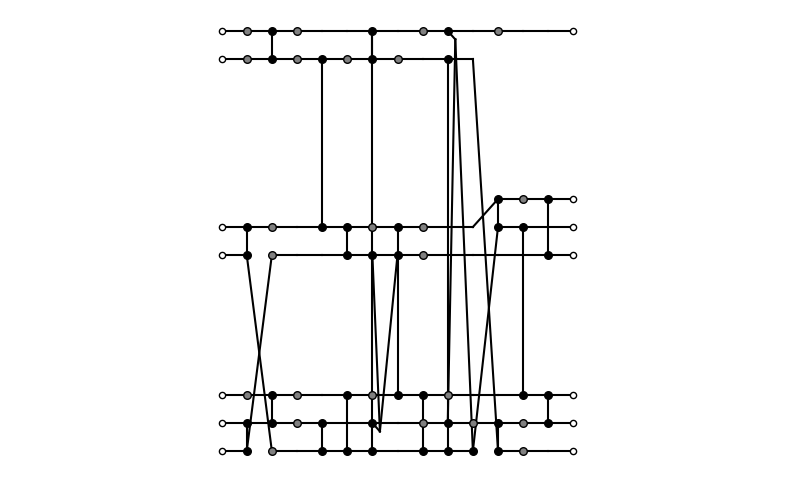

In [146]:
from src.multilevel_FM import MLFM_recursive

limit = num_qubits*depth/16

limit = 'qubit'


assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = limit, 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = True,
                                        add_initial = False,
                                        costs = None)

print(min(cost_list))

assignment = assignment_list[np.argmin(cost_list)]

# layers = circuit_to_gate_layers(circuit)

# layers = group_distributable_packets(layers, num_qubits)

# layers = layer_list_to_dict(layers)

def ungroup_local_gates(layers,assignment):
    for t, layer in layers.items():
        for gate in layer:
            if gate['type'] == 'group':
                root = gate['root']
                print(f"Root: {root}")
                sub_gates = gate['sub-gates']
                gates_to_remove = []
                for i, sub_gate in enumerate(sub_gates):
                    print(f"Sub-gate: {sub_gate}")
                    if assignment[t][root] == assignment[t][sub_gate['qargs'][1]]:
                        print(f"Sub gate is local in partition {assignment[t][root]}")
                        time = sub_gate['time']
                        print(f"Time of sub-gate: {time}")
                        del sub_gate['time']
                        layers[time].append(sub_gate)
                        gates_to_remove.append(sub_gate)
                for i in gates_to_remove:
                    sub_gates.remove(i)

    return layers

def ungroup_local_gates_commute(layers,assignment):
    for t, layer in layers.items():
        for gate in layer:
            if gate['type'] == 'group':
                root = gate['root']
                print(f"Root: {root}")
                sub_gates = gate['sub-gates']
                gates_to_remove = []
                last_t = sub_gates[-1]['time']
                root_parts = {}

                for j in range(t,last_t+1):
                    part = assignment[j][root]
                    if part not in root_parts:
                        root_parts[part] = [j]
                    else:
                        root_parts[part].append(j)

                for i, sub_gate in enumerate(sub_gates):
                    print(f"Sub-gate: {sub_gate}")
                    sub_gate_part = assignment[t][sub_gate['qargs'][1]]
                    if sub_gate_part in root_parts:
                        print(f"Sub gate is local in partition {assignment[t][root]}")
                        time = sub_gate['time']
                        if sub_gate_part == assignment[t][root]:
                            local_time = time
                        else:
                            local_time = root_parts[sub_gate_part][0]
                        print(f"New time of sub-gate: {local_time}")

                        del sub_gate['time']
                        layers[local_time].append(sub_gate)
                        gates_to_remove.append(sub_gate)
                for i in gates_to_remove:
                    sub_gates.remove(i)

    return layers

layers = layers_pre_processing(layers)

layers_ungrouped = ungroup_local_gates_commute(layers,assignment)

layers_ungrouped = layers_pre_processing(layers_ungrouped)

new_graph = QuantumCircuitHyperGraph(num_qubits, depth)

new_graph.map_circuit_to_hypergraph(circuit=None, group_gates=None, anti_diag=None, layers=layers_ungrouped)

mpl_fig = hypergraph_to_matplotlib(
    new_graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)
print(assignment)

In [147]:
print(assignment)

circuit2 = extract_partitioned_circuit(layers_ungrouped, assignment, num_qubits, qpu_info, comm_qubits=[2 for i in range(num_partitions)])

[[0 1 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 0 2 1 0 0 2]
 [1 1 0 1 0 0 2]
 [1 1 0 1 0 0 2]
 [1 1 0 1 0 0 2]]

[extract_partitioned_circuit] Starting extraction...
[extract_partitioned_circuit] num_partitions = 3
[extract_partitioned_circuit] num_qubits = 7
[extract_partitioned_circuit] partition_assignment at t=0: [0 1 2 1 0 0 2]
[extract_partitioned_circuit] qpu_info = [3, 3, 3]
[extract_partitioned_circuit] comm_qubits = [2, 2, 2]
  - Created data register QuantumRegister(3, 'part0_data') with 3 qubits for partition 0
  - Created data register QuantumRegister(3, 'part1_data') with 3 qubits for partition 1
  - Created data register QuantumRegister(3, 'part2_data') with 3 qubits for partition 2
  - Created comm register comm_0_0 with 2 qubits for partition 0
  - Created comm register comm_1_0 with 2 qubits for partition 1
  - Created comm register comm_2_0 with 2 qubits for 

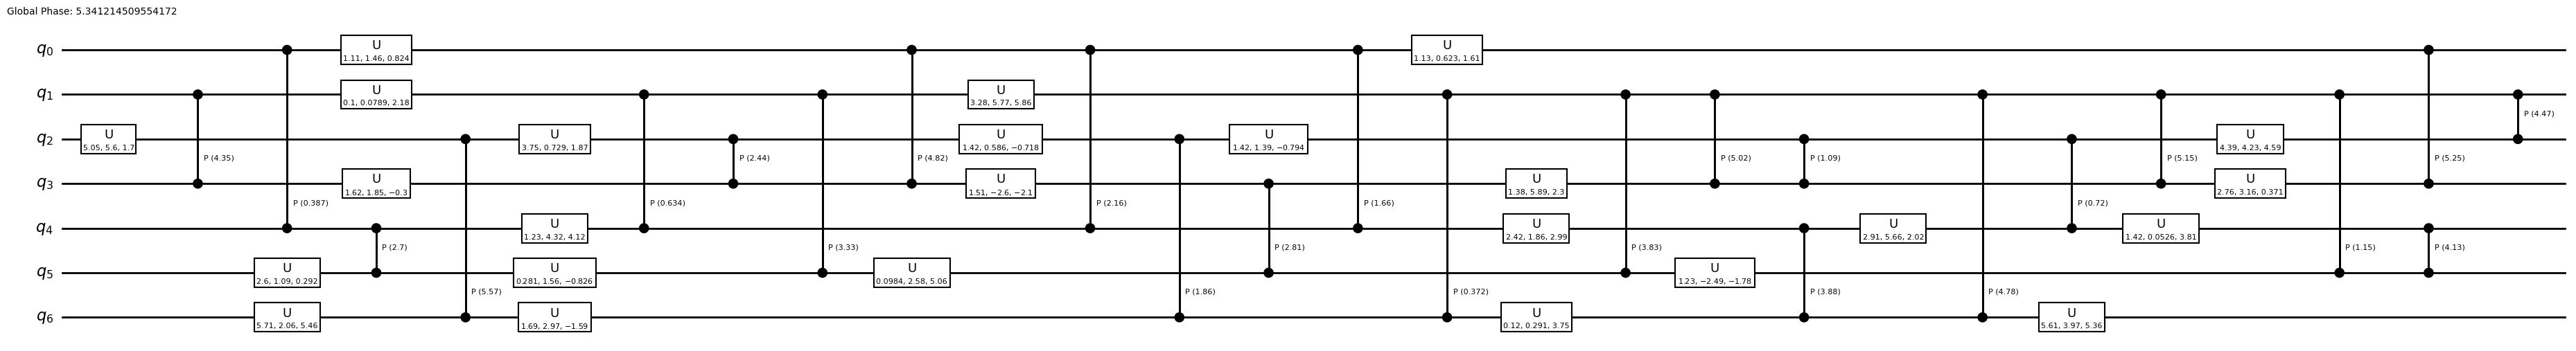

In [148]:
circuit.draw('mpl', fold=100, style='bw')

13
76


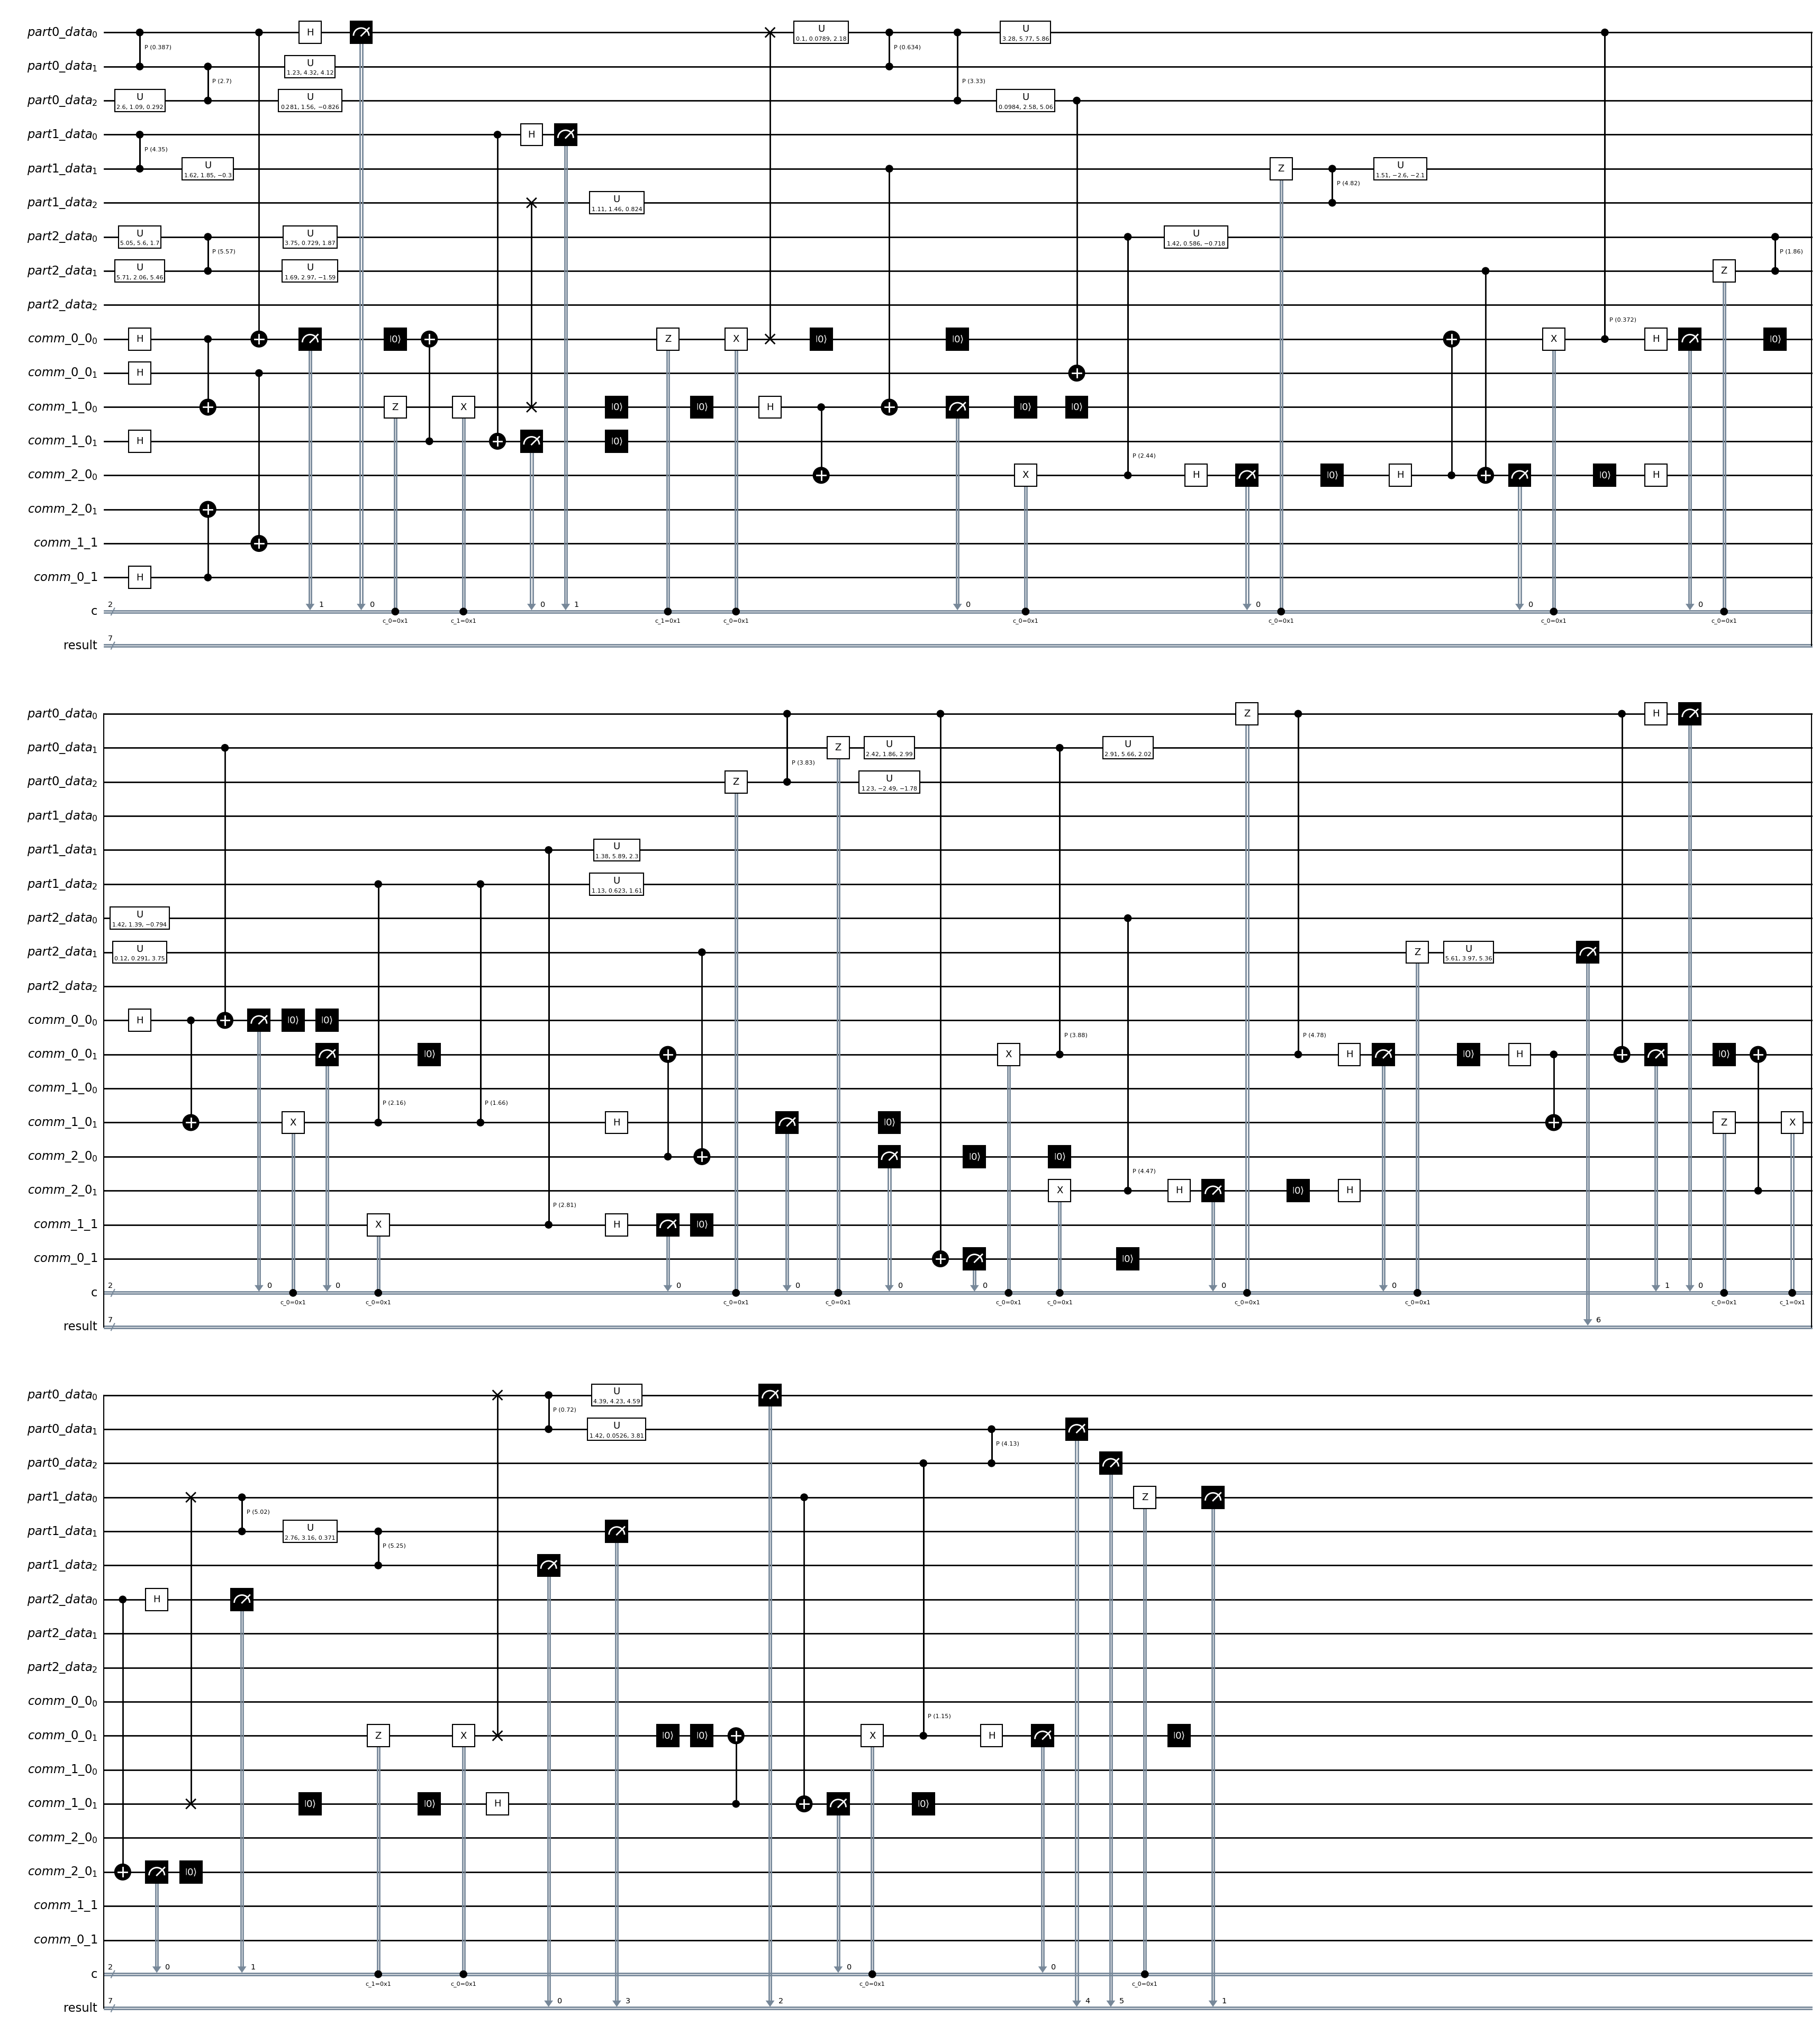

In [149]:
print(circuit.depth())
print(circuit2.depth())
circuit2.draw('mpl',style='bw', fold=50)




In [150]:
# from qiskit_aer import AerSimulator

# simulator = AerSimulator(method='density_matrix')

# # # circuit = transpile(circuit, basis_gates = ['cp', 'u'])

# # result = simulator.run(circuit).result()

# # print(result.get_counts())

# # result1 = simulator.run([circuit1]).result()

# # print(result1.get_counts())

# result2 = simulator.run(circuit2).result()

# print(result2.get_counts())

In [151]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

creg = ClassicalRegister(num_qubits, name="c")

circuit.add_register(creg)

for qubit in range(num_qubits):
    circuit.measure(qubit, creg[qubit])

[]

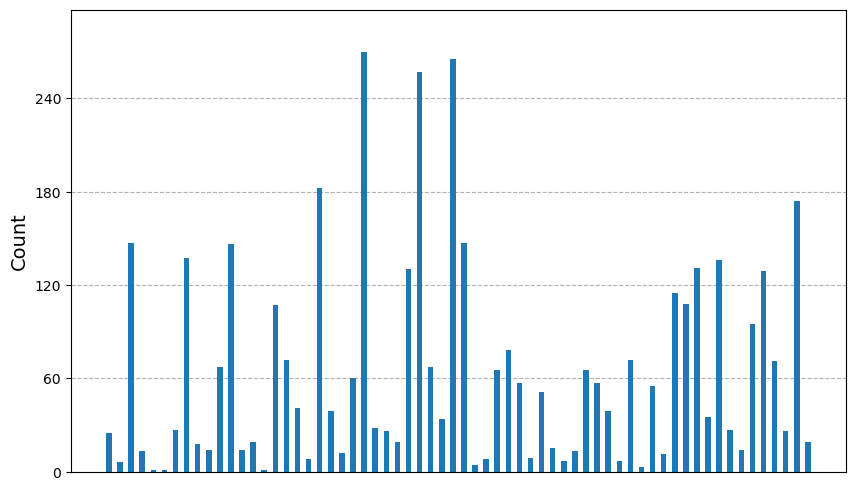

In [152]:
from qiskit_aer.primitives import EstimatorV2, SamplerV2


sampler = SamplerV2()



job = sampler.run([circuit], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_base = data['c'].get_counts()

from qiskit.visualization import plot_histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 6))



plot_histogram(counts_base, bar_labels=False, ax=ax)


ax.set_xticks([])


[]

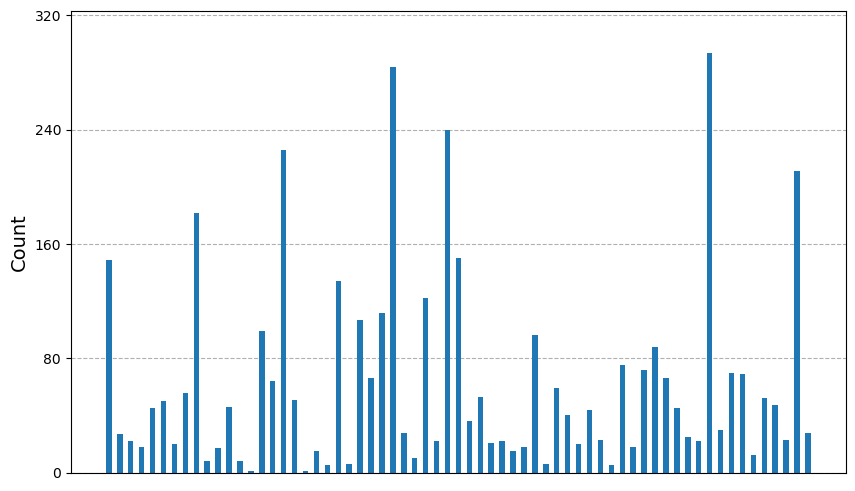

In [153]:

circuit_dec= circuit2.decompose()

sampler = SamplerV2()

job = sampler.run([circuit_dec], shots=4096)
job_result = job.result()
data = job_result[0].data

counts_part2 = data['result'].get_counts()


from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_histogram(data['result'].get_counts(),bar_labels=False,ax=ax)

ax.set_xticks([])


In [154]:
def get_norm(counts1, counts2, shots):
    for key in counts1:
        digits = len(key)
        break

    norm = 0    
    max_string = '1'*digits
    integer = int(max_string, 2)
    for i in range(integer+1):
        binary = bin(i)
        binary = binary[2:]
        binary = '0'*(digits-len(binary)) + binary
        if binary in counts1:
            counts1_val = counts1[binary]
        else:
            counts1_val = 0
        if binary in counts2:
            counts2_val = counts2[binary]
        else:
            counts2_val = 0
        norm += np.abs(counts1_val - counts2_val)
    return norm/shots


In [155]:
sampler = SamplerV2()

shots = 20000


job = sampler.run([circuit], shots=shots)
job_result = job.result()
data = job_result[0].data

counts_base1 = data['c'].get_counts()

job = sampler.run([circuit], shots=shots)
job_result = job.result()
data = job_result[0].data

counts_base2 = data['c'].get_counts()

norm = get_norm(counts_base1, counts_base2, shots)

print(norm)

circuit_dec= circuit2.decompose()
sampler = SamplerV2()

job = sampler.run([circuit_dec], shots = shots)
job_result = job.result()
data = job_result[0].data

counts_part2 = data['result'].get_counts()

norm = get_norm(counts_base1, counts_part2, shots)

print(norm)




0.0622
0.9209
